In [1]:
import io
from itertools import product
import logging; L = logging.getLogger(__name__)
from pathlib import Path
import pickle
import re
import yaml

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../..")
import berp.trainer  # nice yaml dump defaults
from berp.models import load_model
from berp.viz.cluster import cluster_predictor
from berp.viz.trf import plot_trf_coefficients
from berp.viz.trf_em import pipeline_to_dataframe

In [19]:
workflow = "heilbron2022"
lm = "EleutherAI/gpt-neo-2.7B/n10000"

model_paradigm = "cannon_wide"
model_run = "trf-berp-cannon_3quantiles.29720801"
# model_paradigm = "wide"
# model_run = "trf-berp-fixed"

montage = "biosemi128"
# If `None`, use all sensors in model fits
sensors = None

model_dir = f"../../workflow/{workflow}/results{'_' + model_paradigm if model_paradigm is not None else ''}/{lm}/{model_run}"

## Load model

In [20]:
pipe = load_model(model_dir, device="cpu")

In [21]:
print(yaml.safe_dump(pipe.get_params()))

confusion: tensor of type torch.float64, shape torch.Size([40, 40])
encoder: "TemporalReceptiveField(alpha=28096.5569715575, fit_intercept=True,\n   \
  \                    name='be53ad7337d94e7d9f4c6c05f8469081',\n                \
  \       optim=AdamSolver(n_batches=50,\n                                       \
  \ name='be53ad7337d94e7d9f4c6c05f8469081',\n                                   \
  \     random_state=RandomState(MT19937) at 0x2B621A0A7B40),\n                  \
  \     sfreq=128.0, tmax=0.75, tmin=0.0)"
encoder__alpha: 28096.5569715575
encoder__fit_intercept: true
encoder__init_scale: 0.1
encoder__n_outputs: null
encoder__name: be53ad7337d94e7d9f4c6c05f8469081
encoder__optim: "AdamSolver(n_batches=50, name='be53ad7337d94e7d9f4c6c05f8469081',\n\
  \           random_state=RandomState(MT19937) at 0x2B621A0A7B40)"
encoder__optim__batch_size: 512
encoder__optim__early_stopping: 5
encoder__optim__learning_rate: 0.01
encoder__optim__n_batches: 50
encoder__optim__name: be53ad

## Prepare MNE metadata

In [22]:
if sensors is None:
    sensors = next(iter(pipe.encoders_.values())).output_names

for enc in pipe.encoders_.values():
    # TODO relax -- could be a subset. if so will need to subset/reorder later
    assert enc.output_names == sensors
    
sensors

['B22', 'D19', 'A19', 'C22', 'C10', 'C32', 'A7', 'B4']

In [23]:
info = mne.create_info(sensors, pipe.encoder.sfreq, "eeg")
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: B22, D19, A19, C22, C10, C32, A7, B4
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 128.0 Hz
>

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 8


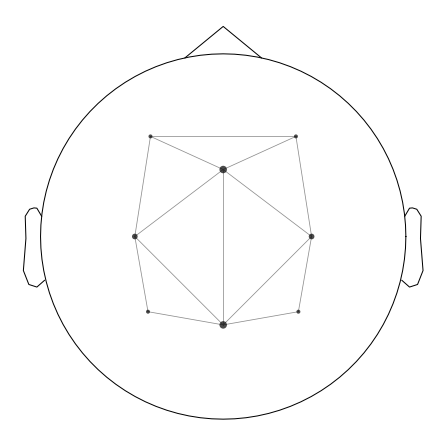

In [24]:
adjacency, ch_names = mne.channels.find_ch_adjacency(info, "eeg")
mne.viz.plot_ch_adjacency(info, adjacency, ch_names)
None

## Clean up model representation

In [25]:
ts_predictor_names, var_predictor_names = pipe.encoder_predictor_names
predictor_names = ts_predictor_names + var_predictor_names

In [26]:
trf_df = pipeline_to_dataframe(pipe)

In [27]:
def get_coef_estimates(trf_df) -> np.ndarray:
    """
    returns n_subjects * n_times * n_channels coefficient representation for
    statistical analysis
    """
    return trf_df.reset_index().set_index(["subject", "epoch_time", "sensor"]).coef.to_numpy() \
        .reshape((len(pipe.encoders_), -1, len(sensors)))

In [28]:
# Sanity check that reading the dataframe is equivalent to reading the raw coefs
t1 = np.stack([
    encoder.coef_[1, :, :]
    for encoder in pipe.encoders_.values()
])
t2 = get_coef_estimates(trf_df[trf_df.predictor_name == predictor_names[1]])
np.testing.assert_almost_equal(t1, t2)

## Test

In [29]:
def prepare_predictor_difference(p1, p2, trf_df):
    """
    compute difference p2 - p1 coefficients
    """
    df = trf_df.reset_index().set_index(["predictor_name", "subject", "epoch_time", "sensor"])
    df = df.loc[[p1, p2]].coef
    ret = (df.loc[p2] - df.loc[p1]).reset_index()
    ret["predictor_name"] = f"{p2} - {p1}"
    
    return ret

In [30]:
def cluster_predictor_(predictor_df, *args, **kwargs):
    if isinstance(predictor_df, str):
        predictor_df = trf_df[trf_df.predictor_name == predictor_df]
    return cluster_predictor(predictor_df, *args, info=info, **kwargs)

## Plot results

### Main effects

  0%|          | 0/12 [00:00<?, ?predictor/s]

var_recognition_onset_0
Using a threshold of 2.100922
stat_fun(H1): min=-7.643379 max=8.116811
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

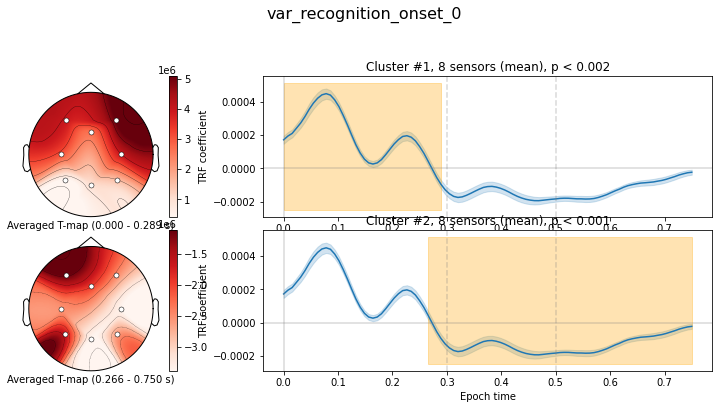

var_recognition_onset_1
Using a threshold of 2.100922
stat_fun(H1): min=-4.702952 max=6.523314
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

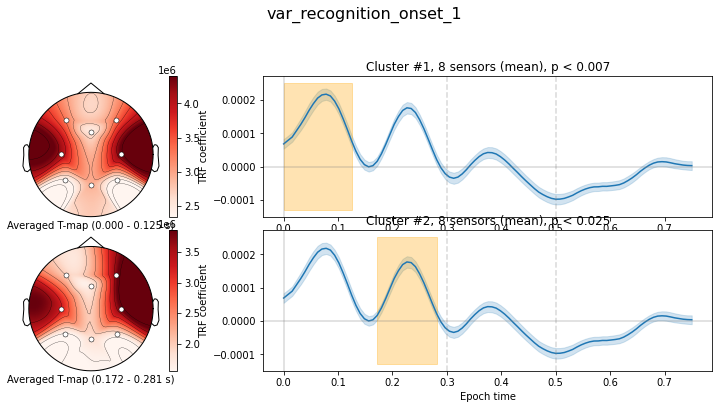

var_recognition_onset_2
Using a threshold of 2.100922
stat_fun(H1): min=-4.465176 max=5.131405
Running initial clustering …
Found 10 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

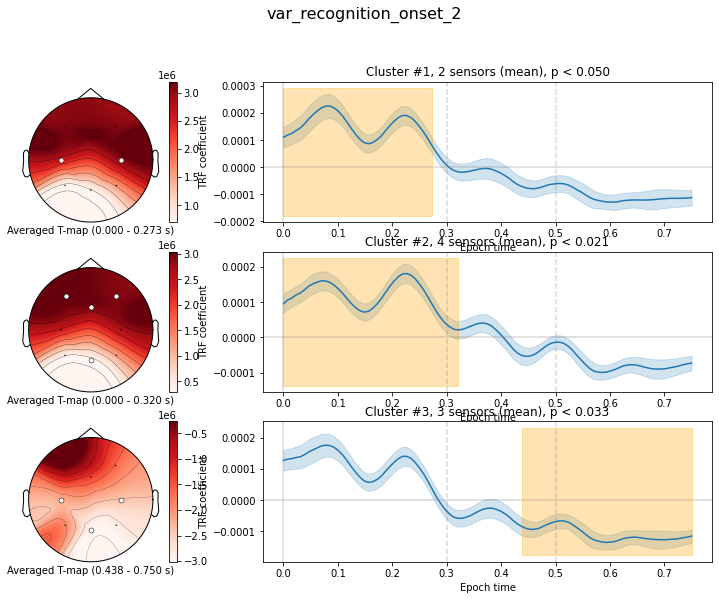

var_recognition_onset_3
Using a threshold of 2.100922
stat_fun(H1): min=-4.169354 max=4.641107
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

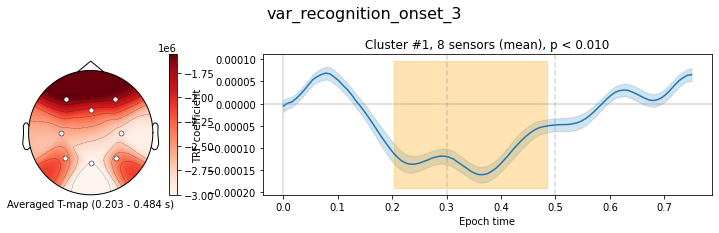

var_word_frequency_0
Using a threshold of 2.100922
stat_fun(H1): min=-5.704874 max=4.172764
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

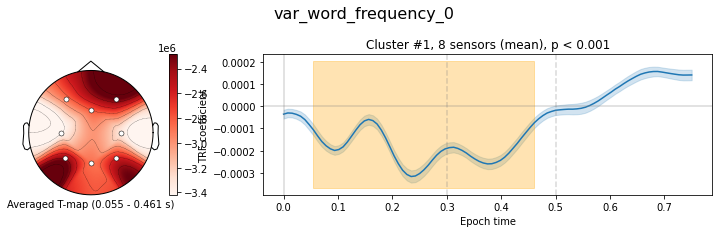

var_word_frequency_1
Using a threshold of 2.100922
stat_fun(H1): min=-4.458365 max=2.730525
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

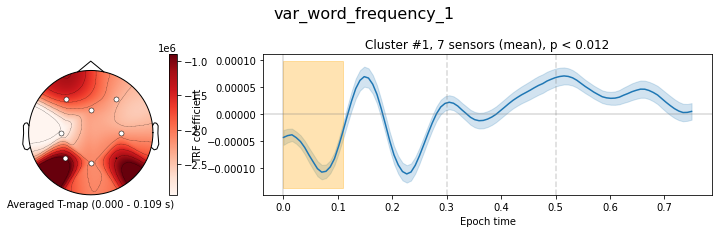

var_word_frequency_2
Using a threshold of 2.100922
stat_fun(H1): min=-5.187830 max=3.819064
Running initial clustering …
Found 9 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

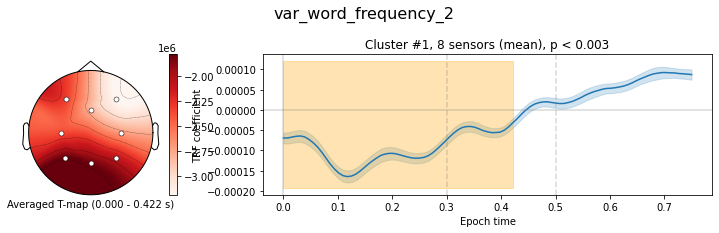

var_word_frequency_3
Using a threshold of 2.100922
stat_fun(H1): min=-5.704531 max=4.044561
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

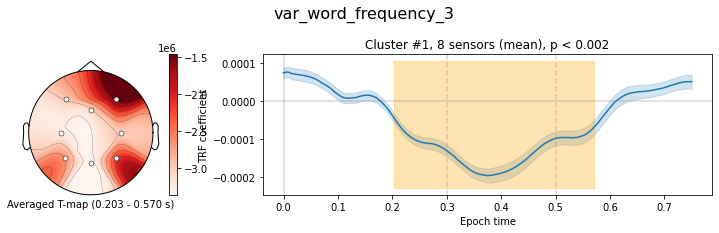

var_word_surprisal_0
Using a threshold of 2.100922
stat_fun(H1): min=-7.632976 max=1.754272
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

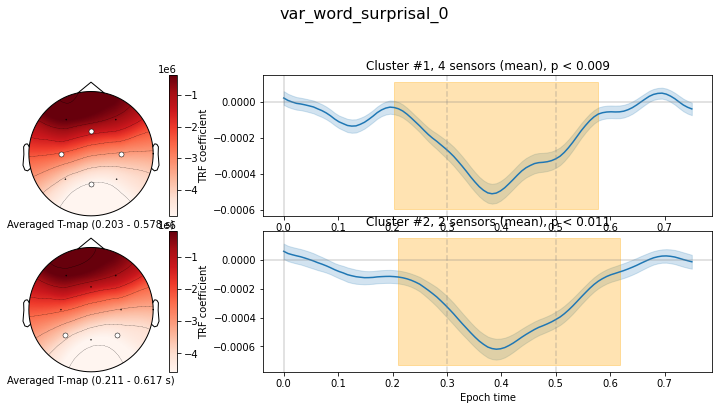

var_word_surprisal_1
Using a threshold of 2.100922
stat_fun(H1): min=-5.914338 max=3.198795
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

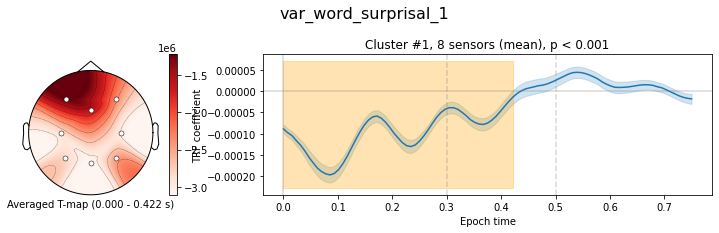

var_word_surprisal_2
Using a threshold of 2.100922
stat_fun(H1): min=-4.033875 max=4.294192
Running initial clustering …
Found 11 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

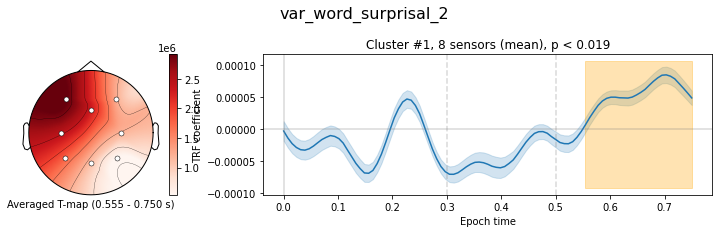

var_word_surprisal_3
Using a threshold of 2.100922
stat_fun(H1): min=-7.018447 max=5.777127
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

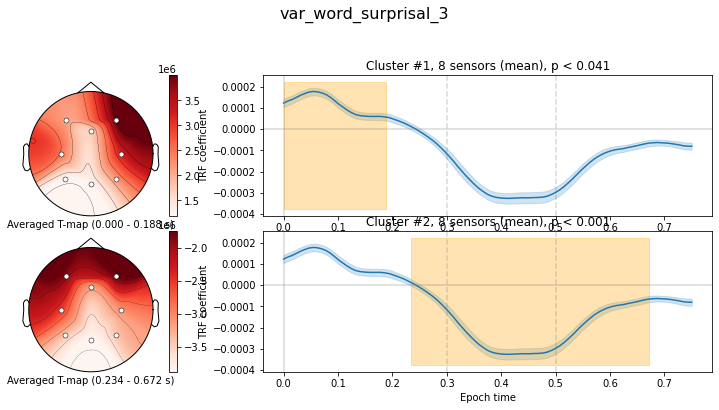

<Figure size 432x288 with 0 Axes>

In [31]:
for name in tqdm(sorted(var_predictor_names), unit="predictor"):
    print(name)
    cluster_predictor_(name, n_jobs=2)

### Cannon differences

In [32]:
cannon_df = trf_df[trf_df.predictor_name.str.contains(r"_\d+$")].copy()
cannon_df[["base_predictor", "quantile"]] = cannon_df.predictor_name.str.rsplit("_", n=1, expand=True)
cannon_df["quantile"] = cannon_df["quantile"].astype(int)
cannon_df

,predictor,lag,sensor,coef,epoch_time,predictor_name,sensor_name,base_predictor,quantile
subject,,,,,,,,,
1,13,0,0,0.000030,0.00,var_recognition_onset_0,B22,var_recognition_onset,0
1,13,0,1,-0.000078,0.00,var_recognition_onset_0,D19,var_recognition_onset,0
1,13,0,2,0.000098,0.00,var_recognition_onset_0,A19,var_recognition_onset,0
1,13,0,3,-0.000249,0.00,var_recognition_onset_0,C22,var_recognition_onset,0
1,13,0,4,-0.000070,0.00,var_recognition_onset_0,C10,var_recognition_onset,0
...,...,...,...,...,...,...,...,...,...
19,24,96,3,-0.000265,0.75,var_word_surprisal_3,C22,var_word_surprisal,3
19,24,96,4,-0.000363,0.75,var_word_surprisal_3,C10,var_word_surprisal,3
19,24,96,5,-0.000368,0.75,var_word_surprisal_3,C32,var_word_surprisal,3


  0%|          | 0/3 [00:00<?, ?predictor/s]

var_recognition_onset
Using a threshold of 2.100922
stat_fun(H1): min=-4.758234 max=3.636222
Running initial clustering …
Found 11 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

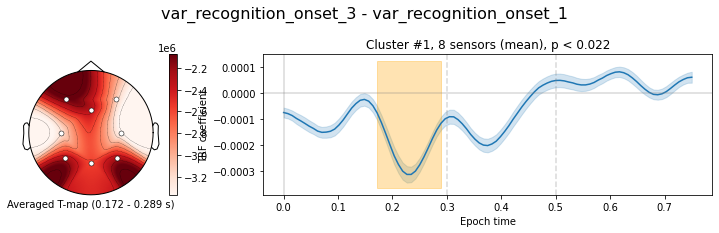

var_word_frequency
Using a threshold of 2.100922
stat_fun(H1): min=-5.192388 max=4.382661
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

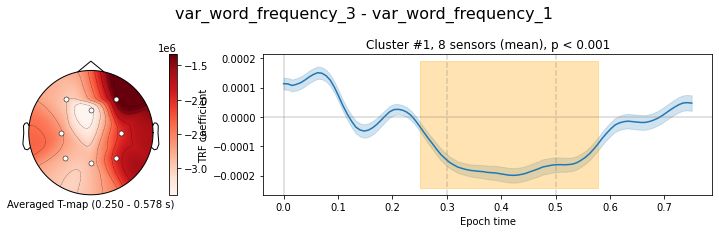

var_word_surprisal
Using a threshold of 2.100922
stat_fun(H1): min=-4.852984 max=6.398086
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

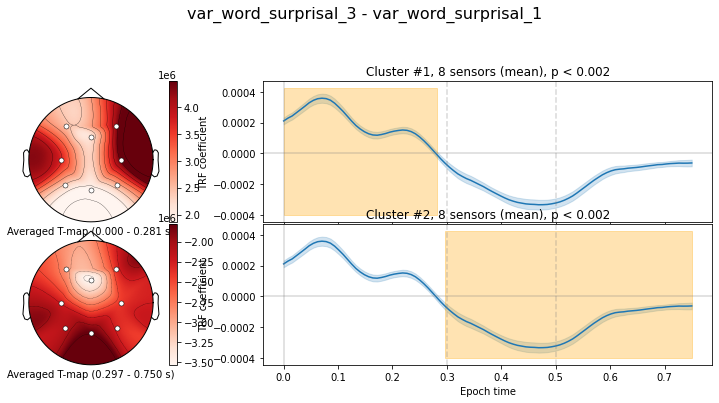

<Figure size 432x288 with 0 Axes>

In [33]:
max_quantile, min_quantile = cannon_df["quantile"].max(), 1
for name in tqdm(sorted(cannon_df.base_predictor.unique()), unit="predictor"):
    print(name)
    cluster_predictor_(
        prepare_predictor_difference(f"{name}_{min_quantile}", f"{name}_{max_quantile}", cannon_df),
        n_jobs=2)
    None